In [1]:
import os
import glob
import json
import numpy as np
import random
import wandb
import threading

import cv2
import math
from scipy.spatial.transform import Rotation as R
from tqdm import tqdm 

import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import CosineAnnealingLR # 상단에 추가
import kornia.augmentation as K


from transformers import AutoModel
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd

NUM_ANGLES = 7
NUM_JOINTS = 8
FEATURE_DIM = 768
HEATMAP_SIZE = (128, 128)

MODEL_NAME = 'facebook/dinov3-vitb16-pretrain-lvd1689m'
MAX_VIEWS_PER_GROUP = 8

# --- 🖥️ 2. GPU 설정 확인 ---
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
if torch.cuda.is_available():
    print(f"✅ 사용 가능한 GPU: {torch.cuda.device_count()}개")
else:
    print("⚠️ GPU를 사용할 수 없습니다. CPU로 실행됩니다.")

# --- 📄 3. CSV 로드 ---
TOTAL_CSV_PATH = '../dataset/franka_research3/fr3_matched_joint_angle.csv'
print(f"\nLoading data from {TOTAL_CSV_PATH}...")
total_csv = pd.read_csv(TOTAL_CSV_PATH)
total_csv.sort_values('robot_timestamp', inplace=True, ignore_index=True)
print("✅ CSV file loaded and sorted successfully.")

# ▼▼▼ [핵심 수정] 그룹핑 로직을 함수로 분리 ▼▼▼
def perform_grouping(df, tolerance, max_views):
    """주어진 tolerance 값으로 데이터프레임을 그룹핑합니다."""
    groups = []
    if not df.empty:
        current_views = []
        for _, row in df.iterrows():
            if not current_views:
                current_views.append(row)
                continue
            start_time = current_views[0]['robot_timestamp']
            if (row['robot_timestamp'] - start_time > tolerance) or (len(current_views) >= max_views):
                joint_angles = [current_views[0][f'position_fr3_joint{j}'] for j in range(1, NUM_ANGLES + 1)]
                image_paths = [{'image_path': view['image_path']} for view in current_views]
                groups.append({'views': image_paths, 'joint_angles': joint_angles})
                current_views = [row]
            else:
                current_views.append(row)
        if current_views:
            joint_angles = [current_views[0][f'position_fr3_joint{j}'] for j in range(1, NUM_ANGLES + 1)]
            image_paths = [{'image_path': view['image_path']} for view in current_views]
            groups.append({'views': image_paths, 'joint_angles': joint_angles})
    return groups

# --- 4. TIME_TOLERANCE 값 그리드 서치 ---
tolerance_candidates = np.round(np.arange(0.05, 0.101, 0.01), 2)
best_tolerance_recommendation = 0
max_full_groups = 0

print(f"\nStarting Grid Search for TIME_TOLERANCE in range: {list(tolerance_candidates)}")
for tolerance in tolerance_candidates:
    # 함수를 호출하여 그룹핑 실행
    temp_groups = perform_grouping(total_csv, tolerance, MAX_VIEWS_PER_GROUP)
    
    # 결과 분석 및 출력
    view_counts = [len(g['views']) for g in temp_groups]
    distribution = pd.Series(view_counts).value_counts().sort_index(ascending=False)
    
    print("-" * 50)
    print(f"Testing Tolerance: {tolerance:.2f} seconds...")
    print(f"  -> Total groups created: {len(temp_groups)}")
    print("  -> View count distribution:")
    print(distribution.to_string())

    current_full_groups = distribution.get(8, 0)
    if current_full_groups > max_full_groups:
        max_full_groups = current_full_groups
        best_tolerance_recommendation = tolerance

print("-" * 50)
print(f"\n🏆 Grid Search Recommendation: TIME_TOLERANCE = {best_tolerance_recommendation} (produced {max_full_groups} full groups)")

# ▼▼▼ [핵심 수정] 사용자로부터 최종 값 입력받기 ▼▼▼
final_tolerance = 0.07
print(f"\nFinal TIME_TOLERANCE set to: {final_tolerance}")
dataset_groups = perform_grouping(total_csv, final_tolerance, MAX_VIEWS_PER_GROUP)
print(f"Total {len(dataset_groups)} groups created before filtering.")


# ▼▼▼ [핵심 수정] 필터링을 먼저 수행합니다. ▼▼▼
groups_before_filtering = len(dataset_groups)
dataset_groups = [group for group in dataset_groups if len(group['views']) > 1]
print(f"ℹ️ Removed {groups_before_filtering - len(dataset_groups)} groups with only 1 view.")


# --- 최종 결과 요약 (필터링 이후) ---
# 필터링이 끝난 최종 dataset_groups를 기준으로 모든 통계를 계산합니다.
print(f"\n✅ Final Total Groups: {len(dataset_groups)}")

total_images_in_groups = sum(len(g['views']) for g in dataset_groups)
print(f"✅ Final Total Images to be used: {total_images_in_groups}")

if dataset_groups:
    view_counts = [len(g['views']) for g in dataset_groups]
    print(f"\n--- Final View count distribution ---")
    print(pd.Series(view_counts).value_counts().sort_index(ascending=False))

/home/najo/.conda/envs/dinov3/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/home/najo/.conda/envs/dinov3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ 사용 가능한 GPU: 1개

Loading data from ../dataset/franka_research3/fr3_matched_joint_angle.csv...
✅ CSV file loaded and sorted successfully.

Starting Grid Search for TIME_TOLERANCE in range: [np.float64(0.05), np.float64(0.06), np.float64(0.07), np.float64(0.08), np.float64(0.09), np.float64(0.1)]
--------------------------------------------------
Testing Tolerance: 0.05 seconds...
  -> Total groups created: 4306
  -> View count distribution:
8     125
6     823
4    1747
2    1611
--------------------------------------------------
Testing Tolerance: 0.06 seconds...
  -> Total groups created: 4306
  -> View count distribution:
8     125
6     823
4    1747
2    1611
--------------------------------------------------
Testing Tolerance: 0.07 seconds...
  -> Total groups created: 3409
  -> View count distribution:
8     641
6     527
4    1688
2     553
--------------------------------------------------
Testing Tolerance: 0.08 seconds...
  -> Total groups created: 3409
  -> View count distr

In [2]:
# ==============================================================================
# 헬퍼 함수 (Ground Truth 생성용)
# ==============================================================================

def create_gt_heatmap(keypoint_2d, HEATMAP_SIZE, sigma):
    """2D 좌표로부터 가우시안 히트맵을 생성합니다."""
    H, W = HEATMAP_SIZE
    x, y = keypoint_2d
    xx, yy = np.meshgrid(np.arange(W), np.arange(H))
    dist_sq = (xx - x)**2 + (yy - y)**2
    heatmap = np.exp(-dist_sq / (2 * sigma**2))
    heatmap[heatmap < np.finfo(float).eps * heatmap.max()] = 0
    return heatmap

def get_modified_dh_matrix(a, d, alpha, theta):
    """Modified DH 파라미터로 변환 행렬 T를 계산합니다."""
    alpha_rad, theta_rad = math.radians(alpha), math.radians(theta)
    cos_th, sin_th = np.cos(theta_rad), np.sin(theta_rad)
    cos_al, sin_al = np.cos(alpha_rad), np.sin(alpha_rad)
    
    # Craig's Modified DH Convention
    T = np.array([
        [cos_th, -sin_th, 0, a],
        [sin_th * cos_al, cos_th * cos_al, -sin_al, -d * sin_al],
        [sin_th * sin_al, cos_th * sin_al,  cos_al,  d * cos_al],
        [0, 0, 0, 1]
    ])
    return T

def angle_to_joint_coordinate(joint_angles, selected_view):
    """[Forward Kinematics] 7개 관절 각도를 8개(베이스 포함)의 3D 공간 좌표로 변환합니다."""
    # Franka Research 3 로봇의 DH 파라미터 (단위: 미터, 도)
    fr3_dh_parameters = [
        {'a': 0,       'd': 0.333, 'alpha': 0,   'theta_offset': 0}, # Joint 1
        {'a': 0,       'd': 0,     'alpha': -90, 'theta_offset': 0}, # Joint 2
        {'a': 0,       'd': 0.316, 'alpha': 90,  'theta_offset': 0}, # Joint 3
        {'a': 0.0825,  'd': 0,     'alpha': 90,  'theta_offset': 0}, # Joint 4
        {'a': -0.0825, 'd': 0.384, 'alpha': -90, 'theta_offset': 0}, # Joint 5
        {'a': 0,       'd': 0,     'alpha': 90,  'theta_offset': 0}, # Joint 6
        {'a': 0.088,   'd': 0,     'alpha': 90,  'theta_offset': 0}, # Joint 7
        {'a': 0,       'd': 0.107, 'alpha': 0,   'theta_offset': 0}  # Flange (End-effector base)
    ]
    
    # 카메라 뷰에 따른 로봇 베이스의 좌표계 보정
    view_rotations = {
        'view1': R.from_euler('zyx', [90, 180, 0], degrees=True),
        'view2': R.from_euler('zyx', [90, 180, 0], degrees=True),
        'view3': R.from_euler('zyx', [90, 180, 0], degrees=True),
        'view4': R.from_euler('zyx', [90, 180, 0], degrees=True)
    }
    
    T_cumulative = np.eye(4)
    if selected_view in view_rotations:
        T_cumulative[:3, :3] = view_rotations[selected_view].as_matrix()

    # J0(베이스) 좌표는 원점
    joint_coords_3d = [np.array([0, 0, 0])] 
    
    origin_point = np.array([0, 0, 0, 1])
    # 각 관절 각도를 순서대로 적용하여 변환 행렬을 누적 곱셈
    for i, angle_rad in enumerate(joint_angles):
        params = fr3_dh_parameters[i]
        theta_deg = math.degrees(angle_rad) + params['theta_offset']
        T_i = get_modified_dh_matrix(params['a'], params['d'], params['alpha'], theta_deg)
        T_cumulative = T_cumulative @ T_i
        
        # 누적된 변환 행렬을 통해 현재 관절의 3D 좌표 계산
        joint_pos_3d = (T_cumulative @ origin_point)[:3]
        joint_coords_3d.append(joint_pos_3d)
        
    return np.array(joint_coords_3d, dtype=np.float32)

def joint_coordinate_to_pixel_plane(coords_3d, aruco_result, camera_matrix, dist_coeffs):
    """[3D-2D 투영] 3D 좌표를 ArUco 마커 기반 카메라 파라미터로 2D 픽셀 평면에 투영합니다."""
    # 카메라 외부 파라미터 (Extrinsics): 월드 좌표계 -> 카메라 좌표계 변환
    rvec = np.array([aruco_result['rvec_x'], aruco_result['rvec_y'], aruco_result['rvec_z']])
    tvec = np.array([aruco_result['tvec_x'], aruco_result['tvec_y'], aruco_result['tvec_z']])
    
    # OpenCV의 projectPoints 함수를 사용하여 3D 포인트를 2D 이미지 평면으로 투영
    pixel_coords, _ = cv2.projectPoints(coords_3d, rvec, tvec, camera_matrix, dist_coeffs)
    return pixel_coords.reshape(-1, 2)

# ==============================================================================
# 2. 멀티뷰 데이터셋 클래스
# ==============================================================================
class RobotPoseDataset(Dataset):
    def __init__(self, groups, transform=None, HEATMAP_SIZE=(128, 128), sigma=5.0):
        self.groups = groups
        self.transform = transform
        self.heatmap_size = HEATMAP_SIZE
        self.sigma = sigma

        print("Loading and preprocessing metadata...")
        # ArUco와 Calibration 데이터를 미리 메모리에 로드하여 I/O 병목을 줄입니다.
        self.aruco_lookup = {}
        for pose_name in ['pose1', 'pose2']:
            aruco_path = f'../dataset/franka_research3/{pose_name}_aruco_pose_summary.json'
            with open(aruco_path, 'r') as f:
                for item in json.load(f):
                    self.aruco_lookup[f"{pose_name}_{item['view']}_{item['cam']}"] = item
        
        self.calib_lookup = {}
        calib_dir = "../dataset/franka_research3/franka_research3_calib_cam_from_conf"
        for calib_path in glob.glob(os.path.join(calib_dir, "*.json")):
            filename = os.path.basename(calib_path).replace("_calib.json", "")
            with open(calib_path, 'r') as f:
                self.calib_lookup[filename] = json.load(f)
        
        self.serial_to_view = {
            '41182735': "view1", '49429257': "view2",
            '44377151': "view3", '49045152': "view4"
        }
        print("✅ Metadata loaded.")

    def __len__(self):
        return len(self.groups)

    def __getitem__(self, idx):
        group = self.groups[idx]
        first_image_path = group.get('views', [{}])[0].get('image_path', f"group_{idx}")
        try:
            gt_angles = torch.tensor(group['joint_angles'], dtype=torch.float32)
            image_dict, gt_heatmaps_dict = {}, {}

            for view_data in group['views']:
                image_path = view_data['image_path']
                
                # --- 경로 분석 ---
                filename = os.path.basename(image_path)
                parts = filename.split('_')
                serial_str, cam_type_str = parts[1], parts[2]
                selected_cam = cam_type_str + "cam"
                selected_view = self.serial_to_view[serial_str]
                
                # ▼▼▼ [핵심 버그 수정] view_key를 고유하게 만듭니다. ▼▼▼
                # (기존) view_key = serial_str 
                # (변경) view_key = f"{serial_str}_{cam_type_str}"  # 예: '41182735_left'
                view_key = f"{serial_str}_{cam_type_str}"

                # --- 이후 로직은 동일 ---
                calib_key = f"{selected_view}_{serial_str}_{selected_cam}"
                calib = self.calib_lookup[calib_key]
                camera_matrix = np.array(calib["camera_matrix"], dtype=np.float32)
                dist_coeffs = np.array(calib["distortion_coeffs"], dtype=np.float32)
                pose_name = 'pose1' if 'pose1' in image_path else 'pose2'
                aruco_key = f"{pose_name}_{selected_view}_{selected_cam}"
                aruco_result = self.aruco_lookup[aruco_key]

                img_bgr = cv2.imread(image_path)
                if img_bgr is None: raise FileNotFoundError(f"Failed to read image")
                img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
                undistorted_np = cv2.undistort(img_rgb, camera_matrix, dist_coeffs)
                
                joint_coords_3d = angle_to_joint_coordinate(group['joint_angles'], selected_view)
                pixel_coords = joint_coordinate_to_pixel_plane(joint_coords_3d, aruco_result, camera_matrix, np.zeros_like(dist_coeffs))
                
                h, w, _ = undistorted_np.shape
                scaled_kpts = pixel_coords * [self.heatmap_size[1]/w, self.heatmap_size[0]/h]
                
                heatmaps_np = np.zeros((NUM_JOINTS, *self.heatmap_size), dtype=np.float32)
                for i in range(NUM_JOINTS):
                    heatmaps_np[i] = create_gt_heatmap(scaled_kpts[i], self.heatmap_size, self.sigma)
                
                image_dict[view_key] = self.transform(Image.fromarray(undistorted_np))
                gt_heatmaps_dict[view_key] = torch.from_numpy(heatmaps_np)

            return image_dict, gt_heatmaps_dict, gt_angles

        except Exception as e:
            # print(f"⚠️ Warning: Skipping group {idx} (e.g., {os.path.basename(first_image_path)}) due to error: {e}")
            return None, None, None

Loading DINOv3 Processor for transformation config...


Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 4969.55it/s]


Resized the image to 224x224

--- Visualizing One Sample For Each Group Size ---
Loading and preprocessing metadata...
✅ Metadata loaded.


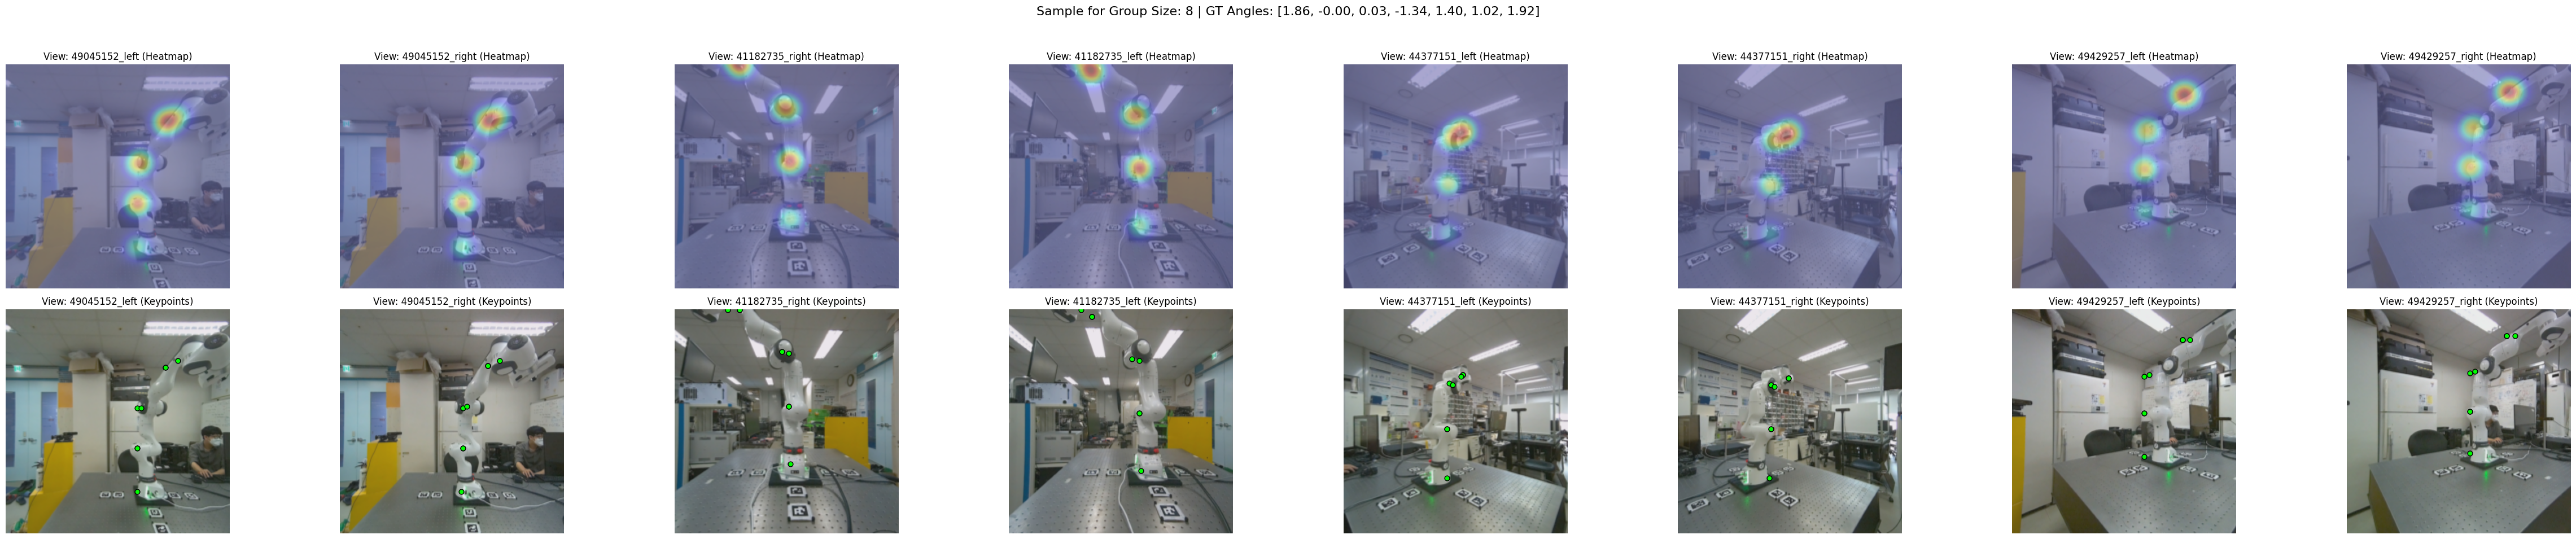

Loading and preprocessing metadata...
✅ Metadata loaded.


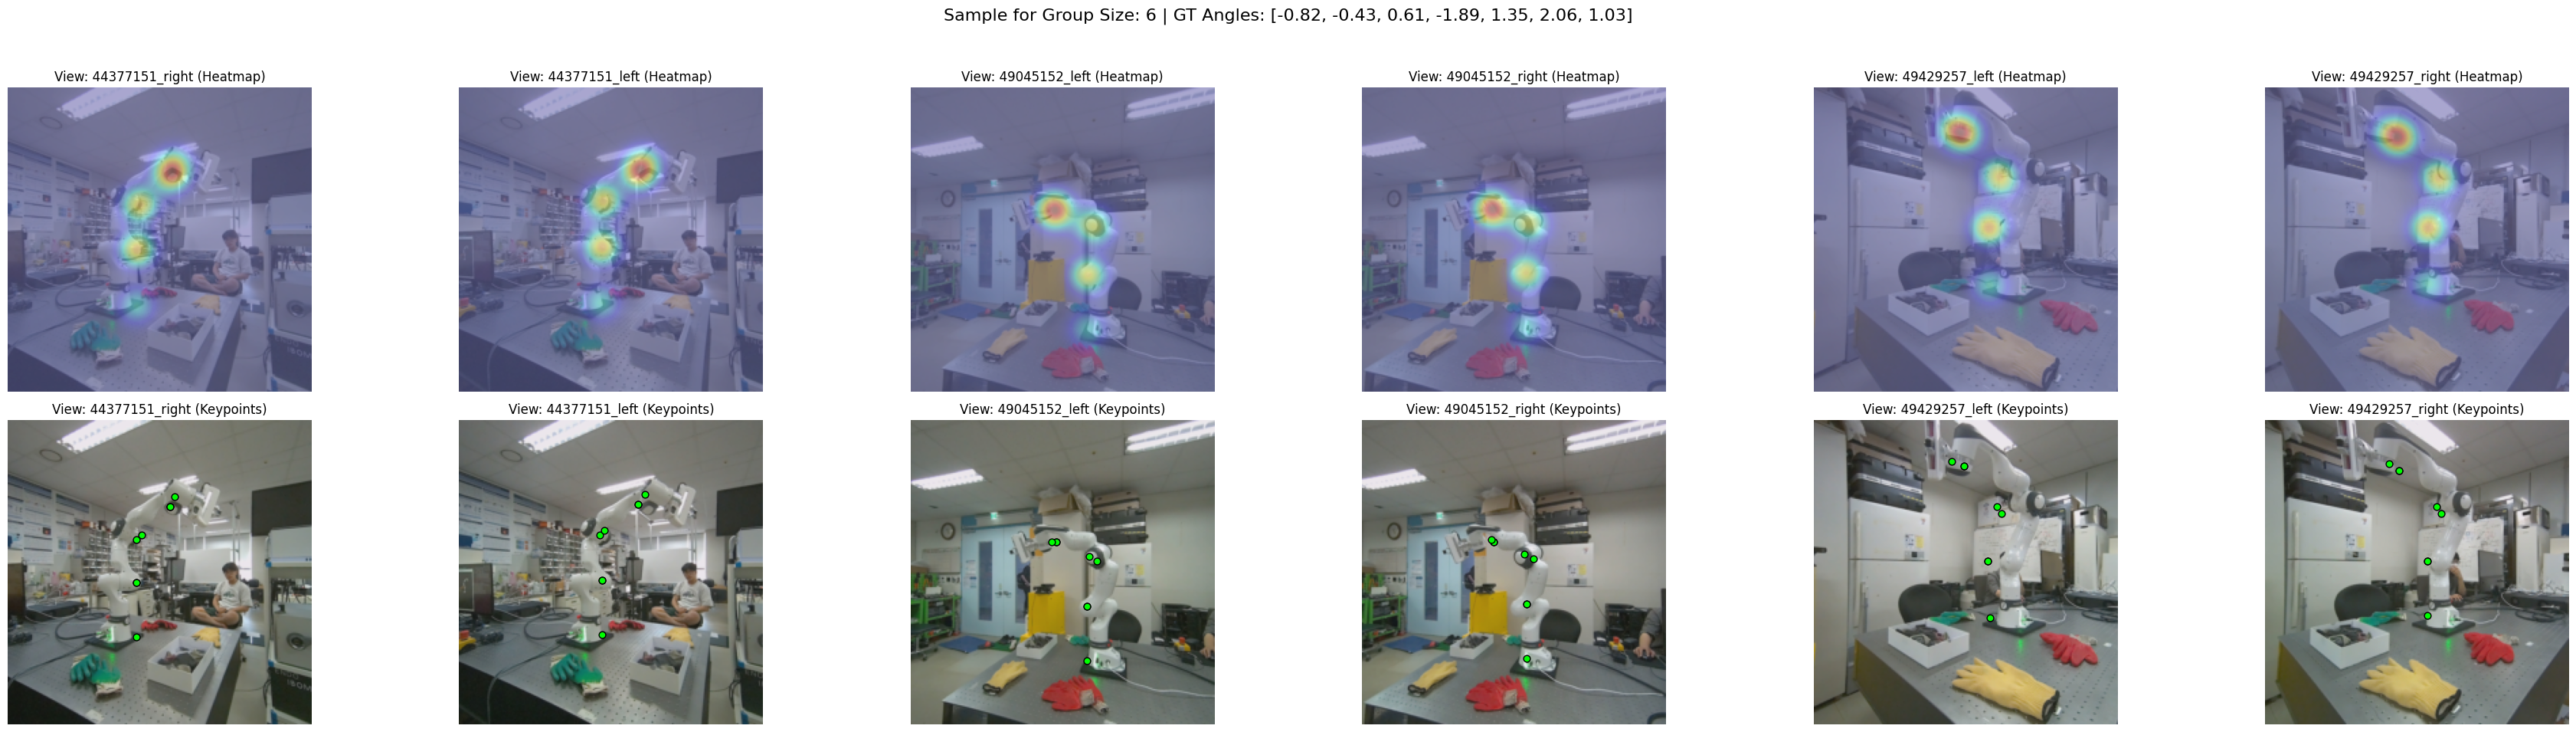

Loading and preprocessing metadata...
✅ Metadata loaded.


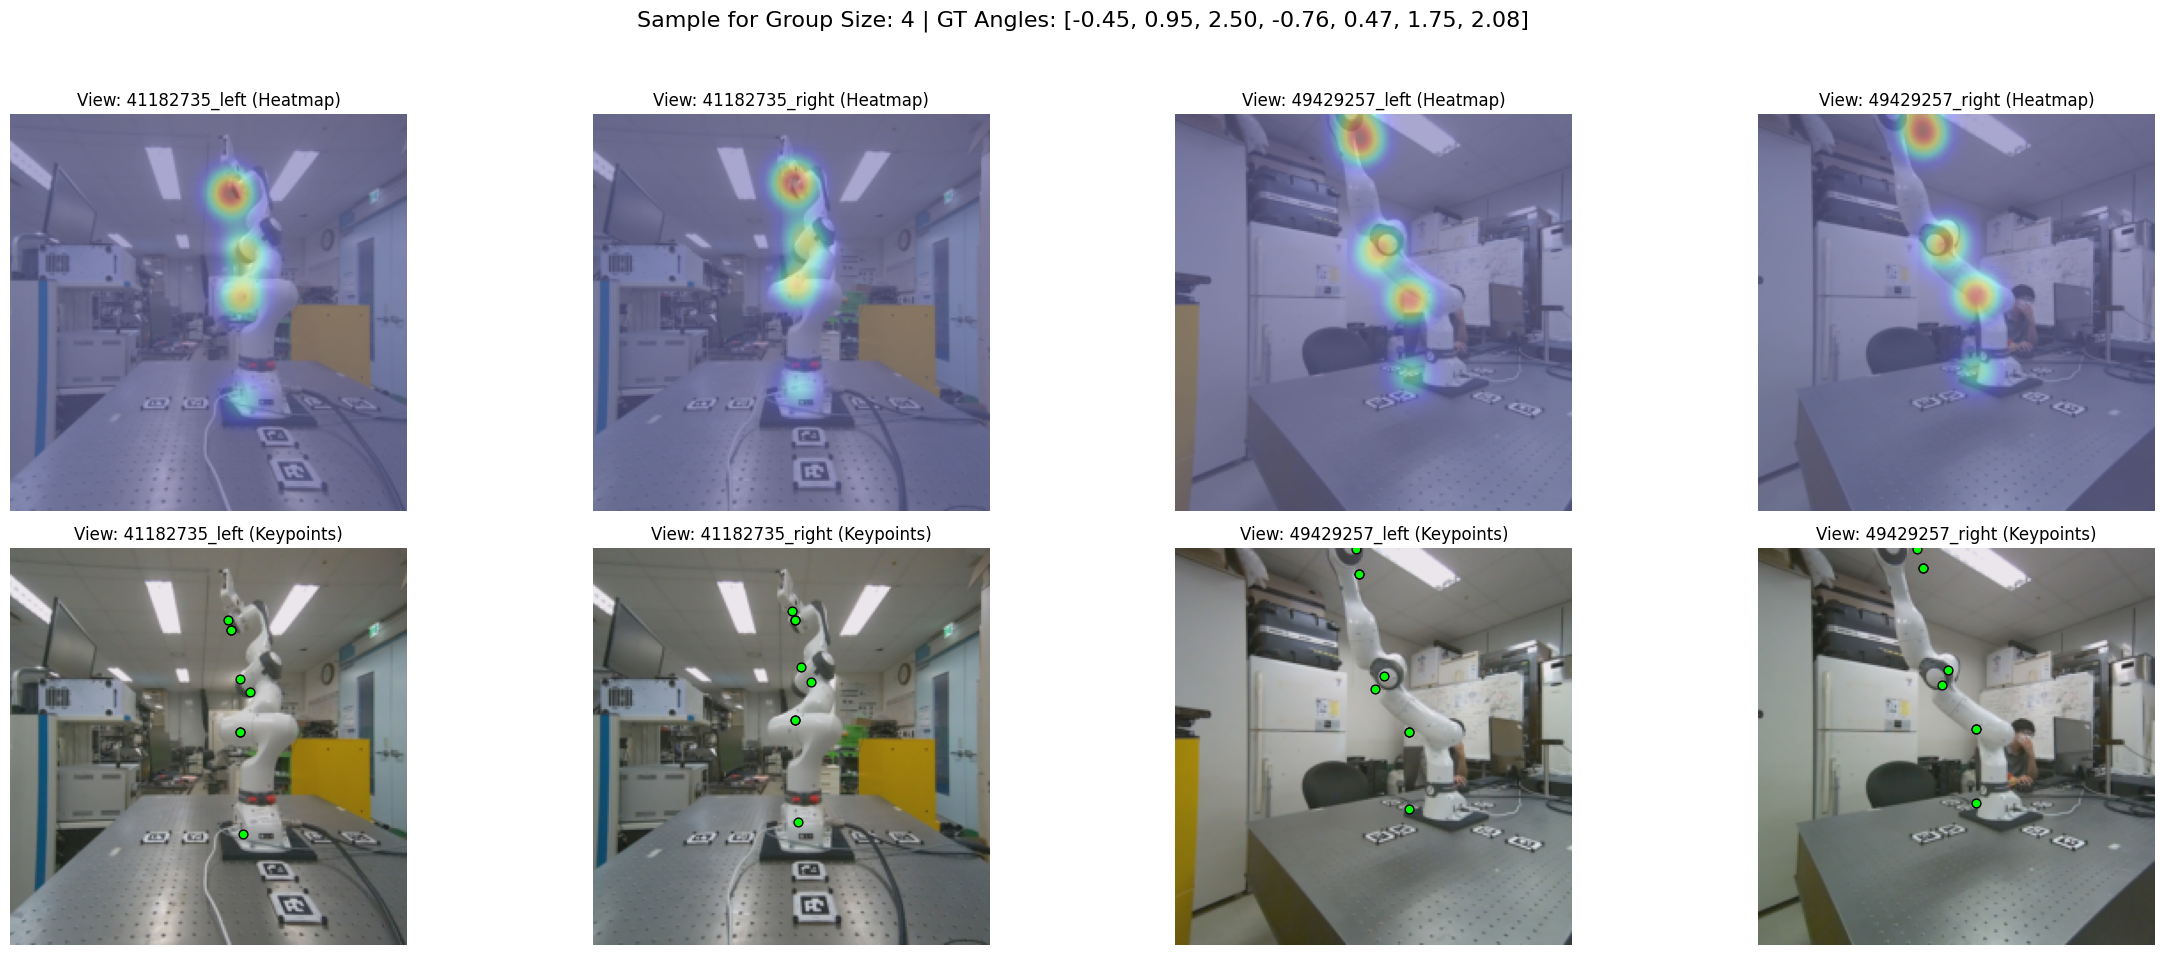

Loading and preprocessing metadata...
✅ Metadata loaded.


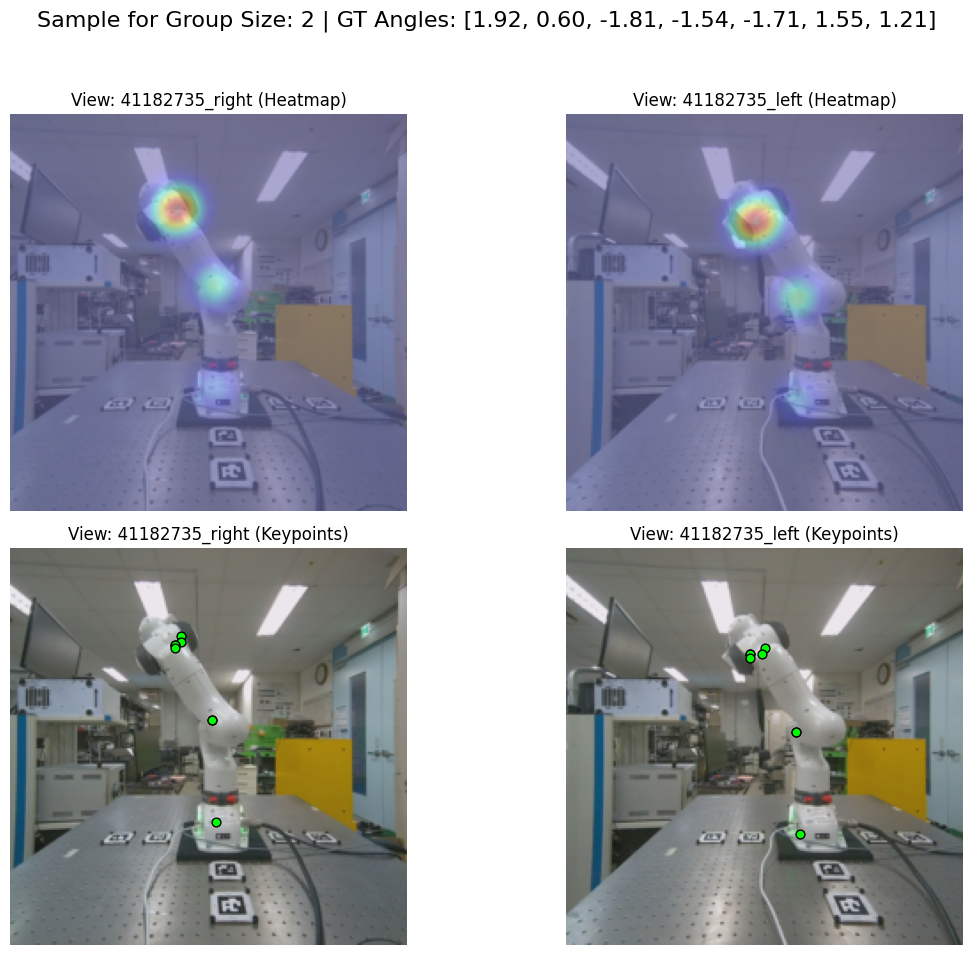

In [3]:
import torch
import torchvision.transforms as transforms
from transformers import AutoImageProcessor
import matplotlib.pyplot as plt
import pandas as pd

# ==============================================================================
# 1. 시각화를 위한 Transform 및 데이터셋 준비 (기존과 동일)
# ==============================================================================

print("Loading DINOv3 Processor for transformation config...")
processor = AutoImageProcessor.from_pretrained(MODEL_NAME)
dino_mean = processor.image_mean
dino_std = processor.image_std

try:
    crop_size = processor.crop_size['height']
    resize_size = processor.size['shortest_edge']
except (TypeError, KeyError):
    print(f"Resized the image to 224x224")
    resize_size = crop_size = 224

vis_transform = transforms.Compose([
    transforms.Resize(resize_size),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=dino_mean, std=dino_std)
])

# ==============================================================================
# 2. 시각화 함수 정의 (수정)
# ==============================================================================

def visualize_samples_by_group_size(groups, transform, mean, std):
    """
    데이터셋에 존재하는 모든 그룹 크기(8, 7, 6...)에 대해
    각각 하나의 샘플을 시각화합니다.
    """
    print("\n--- Visualizing One Sample For Each Group Size ---")
    
    # 그룹 크기별로 데이터를 정리하기 위한 딕셔너리
    groups_by_size = {}
    for group in groups:
        size = len(group['views'])
        if size not in groups_by_size:
            groups_by_size[size] = []
        groups_by_size[size].append(group)

    # 그룹 크기가 큰 순서대로 (8, 7, 6...) 정렬
    sorted_sizes = sorted(groups_by_size.keys(), reverse=True)

    # 각 그룹 크기에 대해 반복
    for size in sorted_sizes:
        # 해당 크기의 그룹 중 하나를 랜덤으로 선택
        sample_group = random.choice(groups_by_size[size])
        
        # 임시 데이터셋을 만들어 __getitem__ 로직 활용
        temp_dataset = RobotPoseDataset(groups=[sample_group], transform=transform)
        image_dict, gt_heatmaps_dict, gt_angles = temp_dataset[0]

        if image_dict is None:
            print(f"Could not process sample for group size {size}. Skipping.")
            continue
            
        # --- 시각화 로직 (기존과 거의 동일) ---
        num_views = len(image_dict)
        fig, axes = plt.subplots(2, num_views, figsize=(6 * num_views, 10))
        if num_views == 1: axes = np.expand_dims(axes, axis=1)

        angle_str = ", ".join([f"{a:.2f}" for a in gt_angles.numpy()])
        fig.suptitle(f"Sample for Group Size: {num_views} | GT Angles: [{angle_str}]", fontsize=16)

        for j, view_key in enumerate(image_dict.keys()):
            img_tensor = image_dict[view_key]
            img_np = img_tensor.numpy().transpose(1, 2, 0)
            img_np = np.array(std) * img_np + np.array(mean)
            img_np = np.clip(img_np, 0, 1)
            H, W, _ = img_np.shape

            gt_heatmaps = gt_heatmaps_dict[view_key]
            composite_heatmap = torch.sum(gt_heatmaps, dim=0).numpy()
            heatmap_resized = cv2.resize(composite_heatmap, (W, H))

            keypoints = []
            h_map, w_map = gt_heatmaps.shape[1:]
            for k in range(gt_heatmaps.shape[0]):
                y, x = np.unravel_index(torch.argmax(gt_heatmaps[k]).numpy(), (h_map, w_map))
                keypoints.append([x * (W / w_map), y * (H / h_map)])
            keypoints = np.array(keypoints)

            ax = axes[0, j]
            ax.imshow(img_np, alpha=0.7)
            ax.imshow(heatmap_resized, cmap='jet', alpha=0.3)
            ax.set_title(f"View: {view_key} (Heatmap)")
            ax.axis('off')

            ax = axes[1, j]
            ax.imshow(img_np)
            ax.scatter(keypoints[:, 0], keypoints[:, 1], c='lime', s=40, edgecolors='black', linewidth=1)
            ax.set_title(f"View: {view_key} (Keypoints)")
            ax.axis('off')
            
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

# ==============================================================================
# 3. 시각화 실행
# ==============================================================================
# 최종적으로 필터링된 dataset_groups를 사용하여 시각화 함수 호출
visualize_samples_by_group_size(dataset_groups, 
                                transform=vis_transform, 
                                mean=dino_mean, 
                                std=dino_std)

In [4]:
class DINOv3Backbone(nn.Module):
    """
    Hugging Face transformers 라이브러리를 사용하여 DINOv3 모델을 구성합니다.
    사전에 정규화된 이미지 텐서 배치를 입력받아 패치 토큰을 반환합니다.
    """
    def __init__(self, model_name=MODEL_NAME): # ViT-Base 모델을 기본값으로 사용
        super().__init__()
        # 사전 학습된 DINOv3 모델을 불러옵니다.
        self.model = AutoModel.from_pretrained(model_name)
        # ⚠️ 참고: 모델을 특정 장치(.to('cuda'))로 보내는 코드는
        # 메인 학습 스크립트에서 한 번에 처리하는 것이 좋습니다.

    def forward(self, image_tensor_batch):
        """
        Args:
            image_tensor_batch (torch.Tensor): (B, C, H, W) 형태의 정규화된 이미지 텐서
        """
        # 그래디언트 계산을 비활성화합니다.
        with torch.no_grad():
            # Hugging Face 모델은 'pixel_values'라는 키워드 인자를 기대합니다.
            outputs = self.model(pixel_values=image_tensor_batch)

        last_hidden_state = outputs.last_hidden_state
        
        # 클래스 토큰(CLS)을 제외한 패치 토큰들만 반환합니다.
        patch_tokens = last_hidden_state[:, 1:, :]
        
        return patch_tokens

class JointAngleHead(nn.Module):
    def __init__(self, input_dim=FEATURE_DIM, num_angles=NUM_ANGLES, num_queries=4, nhead=8, num_decoder_layers=2):
        super().__init__()
        
        # 1. "로봇 포즈에 대해 질문하는" 학습 가능한 쿼리 토큰 생성
        self.pose_queries = nn.Parameter(torch.randn(1, num_queries, input_dim))
        
        # 2. PyTorch의 표준 Transformer Decoder 레이어 사용
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=input_dim, 
            nhead=nhead, 
            dim_feedforward=input_dim * 4, # 일반적인 설정
            dropout=0.1, 
            activation='gelu',
            batch_first=True  # (batch, seq, feature) 입력을 위함
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)
        
        # 3. 최종 각도 예측을 위한 MLP
        # 디코더를 거친 모든 쿼리 토큰의 정보를 사용
        self.angle_predictor = nn.Sequential(
            nn.LayerNorm(input_dim * num_queries),
            nn.Linear(input_dim * num_queries, 512),
            nn.GELU(),
            nn.LayerNorm(512),
            nn.Linear(512, 256),
            nn.GELU(),
            nn.LayerNorm(256),
            nn.Linear(256, num_angles)
        )

    def forward(self, fused_features):
        # fused_features: DINOv2의 패치 토큰들 (B, Num_Patches, Dim)
        # self.pose_queries: 학습 가능한 쿼리 (1, Num_Queries, Dim)
        
        # 배치 사이즈만큼 쿼리를 복제
        b = fused_features.size(0)
        queries = self.pose_queries.repeat(b, 1, 1)
        
        # Transformer Decoder 연산
        # 쿼리(queries)가 이미지 특징(fused_features)에 어텐션을 수행하여
        # 포즈와 관련된 정보로 자신의 값을 업데이트합니다.
        attn_output = self.transformer_decoder(tgt=queries, memory=fused_features)
        
        # 업데이트된 쿼리 토큰들을 하나로 펼쳐서 MLP에 전달
        output_flat = attn_output.flatten(start_dim=1)
        
        return self.angle_predictor(output_flat)

class MultiViewFusion(nn.Module):
    """
    Latent Query 기반의 Multi-view Fusion 모듈.
    """
    def __init__(self, feature_dim=FEATURE_DIM, num_heads=8, dropout=0.1, num_queries=16, num_layers=2):
        super().__init__()
        # 씬 전체의 정보를 요약할 학습 가능한 글로벌 쿼리
        self.global_queries = nn.Parameter(torch.randn(1, num_queries, feature_dim))
        
        # Cross-Attention + Self-Attention으로 구성된 Transformer Decoder 레이어
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=feature_dim, nhead=num_heads, dim_feedforward=feature_dim * 4,
            dropout=dropout, activation='gelu', batch_first=True
        )
        self.fusion_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

    def forward(self, view_features: list):
        # 1. 모든 뷰의 토큰들을 시퀀스 차원에서 하나로 합침
        all_view_tokens = torch.cat(view_features, dim=1)
        b = all_view_tokens.size(0)
        
        # 2. 배치 사이즈만큼 글로벌 쿼리 복제
        queries = self.global_queries.repeat(b, 1, 1)
        
        # 3. Decoder를 통해 쿼리가 모든 뷰의 정보를 요약하도록 함
        # 쿼리가 Key/Value인 all_view_tokens에 Cross-Attention을 수행하고,
        # 이후 쿼리들끼리 Self-Attention을 수행하며 정보를 정제함
        fused_queries = self.fusion_decoder(tgt=queries, memory=all_view_tokens)
        
        return fused_queries

class TokenFuser(nn.Module):
    """
    ViT의 패치 토큰(1D 시퀀스)을 CNN이 사용하기 좋은 2D 특징 맵으로 변환하고 정제합니다.
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.projection = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.refine_blocks = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.residual_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    def forward(self, x):
        # x: (B, D, H, W) 형태로 reshape된 토큰 맵
        projected = self.projection(x)
        refined = self.refine_blocks(projected)
        residual = self.residual_conv(x)
        return torch.nn.functional.gelu(refined + residual)

class LightCNNStem(nn.Module):
    def __init__(self):
        super().__init__()
        # 간단한 CNN 블록 구성
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1, bias=False), # 해상도 1/2
            nn.BatchNorm2d(16),
            nn.GELU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1, bias=False), # 해상도 1/4
            nn.BatchNorm2d(32),
            nn.GELU()
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, bias=False), # 해상도 1/8
            nn.BatchNorm2d(64),
            nn.GELU()
        )
        
    def forward(self, x):
        # x: 원본 이미지 텐서 배치 (B, 3, H, W)
        feat_4 = self.conv_block1(x)  # 1/4 스케일 특징
        feat_8 = self.conv_block2(feat_4) # 1/8 스케일 특징
        return feat_4, feat_8 # 다른 해상도의 특징들을 반환

class FusedUpsampleBlock(nn.Module):
    """
    업샘플링된 특징과 CNN 스템의 고해상도 특징(스킵 연결)을 융합하는 블록.
    """
    def __init__(self, in_channels, skip_channels, out_channels):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.refine_conv = nn.Sequential(
            nn.Conv2d(in_channels + skip_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.GELU()
        )

    def forward(self, x, skip_feature):
        x = self.upsample(x)
        
        # ✅ 해결책: skip_feature를 x의 크기에 강제로 맞춥니다.
        # ----------------------------------------------------------------------
        # 두 텐서의 높이와 너비가 다를 경우, skip_feature를 x의 크기로 리사이즈합니다.
        if x.shape[-2:] != skip_feature.shape[-2:]:
            skip_feature = F.interpolate(
                skip_feature, 
                size=x.shape[-2:], # target H, W
                mode='bilinear', 
                align_corners=False
            )
        # ----------------------------------------------------------------------
        
        # 이제 두 텐서의 크기가 같아졌으므로 안전하게 합칠 수 있습니다.
        fused = torch.cat([x, skip_feature], dim=1)
        return self.refine_conv(fused)
    
class UNetViTKeypointHead(nn.Module):
    def __init__(self, input_dim=768, num_joints=7, heatmap_size=(128, 128)):
        super().__init__()
        self.heatmap_size = heatmap_size
        self.token_fuser = TokenFuser(input_dim, 256)
        self.decoder_block1 = FusedUpsampleBlock(in_channels=256, skip_channels=64, out_channels=128)
        self.decoder_block2 = FusedUpsampleBlock(in_channels=128, skip_channels=32, out_channels=64)
        self.final_upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.heatmap_predictor = nn.Conv2d(64, num_joints, kernel_size=3, padding=1)

    def forward(self, dino_features, cnn_features):
        cnn_feat_4, cnn_feat_8 = cnn_features

        # 1. DINOv3 토큰을 표준 ViT 패치 개수인 196개로 잘라내고 2D 맵으로 변환
        num_patches_to_keep = 196
        dino_features_sliced = dino_features[:, :num_patches_to_keep, :]
        
        b, n, d = dino_features_sliced.shape
        h = w = int(n**0.5)
        x = dino_features_sliced.permute(0, 2, 1).reshape(b, d, h, w)

        x = self.token_fuser(x)

        # 2. 디코더 업샘플링 & 융합
        x = self.decoder_block1(x, cnn_feat_8)
        x = self.decoder_block2(x, cnn_feat_4)
        
        # 3. 최종 해상도로 업샘플링 및 예측
        x = self.final_upsample(x)
        heatmaps = self.heatmap_predictor(x)
        
        return F.interpolate(heatmaps, size=self.heatmap_size, mode='bilinear', align_corners=False)
    
class DINOv3PoseEstimator(nn.Module):
    """
    [전체 아키텍처 (Overall Architecture)]
    Multi-view 이미지들을 입력받아, 각 뷰의 특징을 추출하고 융합하여
    하나의 통합된 관절 각도(global pose)와 각 뷰에 대한 키포인트 히트맵(local keypoints)을 예측합니다.
    """
    def __init__(self, model_name=MODEL_NAME, num_joints=NUM_JOINTS, num_angles=NUM_ANGLES, max_views=10):
        super().__init__()
        
        # 1. 백본: 고차원 의미 정보 추출
        self.backbone = DINOv3Backbone(model_name)
        feature_dim = self.backbone.model.config.hidden_size
        
        # ▼▼▼ [수정 1] 뷰 임베딩을 유연하게 처리하기 위한 변경 ▼▼▼
        # 최대 처리 가능한 카메라(뷰) 개수를 기반으로 임베딩 레이어 생성
        self.view_embeddings = nn.Embedding(max_views, feature_dim)
        
        # forward 시점에 뷰 이름/시리얼과 인덱스를 동적으로 매핑할 딕셔너리
        self.view_to_idx = {} 
        self.next_view_idx = 0

        # 3. CNN 스템: 저차원 공간 정보 추출
        self.cnn_stem = LightCNNStem()
        
        # 4. 퓨전 모듈: 모든 뷰의 정보를 하나의 전역 요약 정보로 압축
        self.fusion_module = MultiViewFusion(feature_dim=feature_dim)
        
        # 5. 헤드 (예측기)
        self.angle_head = JointAngleHead(input_dim=feature_dim, num_angles=num_angles, num_queries=16)
        self.keypoint_head = UNetViTKeypointHead(input_dim=feature_dim, num_joints=num_joints)
        self.keypoint_enricher = nn.TransformerDecoderLayer(
            d_model=feature_dim, nhead=8, dim_feedforward=feature_dim * 4,
            dropout=0.1, activation='gelu', batch_first=True
        )

    def forward(self, multi_view_images: dict):
        all_dino_features_with_embed = []
        all_cnn_features = {}
        view_keys_ordered = list(multi_view_images.keys())

        # --- Step 1: 각 뷰에 대한 병렬 특징 추출 ---
        for view_key in view_keys_ordered:
            view_tensor = multi_view_images[view_key]
            dino_features = self.backbone(view_tensor)
            
            if view_key not in self.view_to_idx:
                if self.next_view_idx >= self.view_embeddings.num_embeddings:
                    raise ValueError(f"Exceeded maximum number of views ({self.view_embeddings.num_embeddings}).")
                self.view_to_idx[view_key] = self.next_view_idx
                self.next_view_idx += 1
            
            view_idx = self.view_to_idx[view_key]
            
            embedding = self.view_embeddings(
                torch.tensor([view_idx], device=dino_features.device)
            ).unsqueeze(0)
            all_dino_features_with_embed.append(dino_features + embedding)
            
            all_cnn_features[view_key] = self.cnn_stem(view_tensor)

        # --- Step 2: Multi-view 정보 융합 ---
        # Latent Query를 통해 모든 뷰의 DINO 특징을 'fused_queries'라는 전역 정보로 요약
        fused_queries = self.fusion_module(all_dino_features_with_embed)
        
        # --- Step 3: 관절 각도 예측 ---
        # 요약된 전역 정보로부터 직접 관절 각도를 예측
        predicted_angles = self.angle_head(fused_queries)
        
        # --- Step 4: 키포인트 히트맵 예측 ---
        predicted_heatmaps_dict = {}
        for i, view_name in enumerate(view_keys_ordered):
            enriched_tokens = self.keypoint_enricher(
                tgt=all_dino_features_with_embed[i], 
                memory=fused_queries
            )
            heatmap = self.keypoint_head(enriched_tokens, all_cnn_features[view_name])
            predicted_heatmaps_dict[view_name] = heatmap
        
        return predicted_heatmaps_dict, predicted_angles

In [5]:
# ==============================================================================
# Cell 5: 학습/검증용 시각화 함수
# ==============================================================================

def visualize_dataset_sample(dataset, mean, std, num_samples=1):
    """데이터셋의 GT 샘플을 시각화하여 데이터 파이프라인을 검증합니다."""
    print("\n--- Visualizing Dataset Samples ---")
    # (이전 Cell 3에서 사용했던 visualize_final_groups 함수와 거의 동일한 로직)
    for i in range(num_samples):
        while True:
            idx = random.randint(0, len(dataset) - 1)
            sample = dataset[idx]
            if sample[0] is not None: break
        
        image_dict, gt_heatmaps_dict, gt_angles = sample
        num_views = len(image_dict)
        fig, axes = plt.subplots(1, num_views, figsize=(6 * num_views, 6))
        if num_views == 1: axes = [axes]

        angle_str = ", ".join([f"{a:.2f}" for a in gt_angles.numpy()])
        fig.suptitle(f"Sample Group {idx} | GT Angles: [{angle_str}]", fontsize=16)

        for j, view_key in enumerate(image_dict.keys()):
            img_tensor = image_dict[view_key]
            img_np = (img_tensor.numpy().transpose(1, 2, 0) * np.array(std)) + np.array(mean)
            img_np = np.clip(img_np, 0, 1)
            H, W, _ = img_np.shape

            gt_heatmaps = gt_heatmaps_dict[view_key]
            heatmap_resized = cv2.resize(torch.sum(gt_heatmaps, dim=0).numpy(), (W, H))
            
            axes[j].imshow(img_np, alpha=0.7)
            axes[j].imshow(heatmap_resized, cmap='jet', alpha=0.3)
            axes[j].set_title(f"View: {view_key} (GT Heatmap)")
            axes[j].axis('off')
            
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

def visualize_predictions(model, dataset, device, mean, std, epoch_num, num_samples=1):
    """검증 데이터셋 샘플에 대한 모델의 예측 결과를 GT와 함께 시각화합니다."""
    print(f"\n--- Visualizing Predictions for Epoch {epoch_num} ---")
    model.eval()
    figures = []
    
    for i in range(num_samples):
        while True:
            idx = random.randint(0, len(dataset) - 1)
            sample = dataset[idx]
            if sample[0] is not None: break

        image_dict, gt_heatmaps_dict, gt_angles = sample

        with torch.no_grad():
            input_batch = {k: v.unsqueeze(0).to(device) for k, v in image_dict.items()}
            pred_heatmaps_dict, pred_angles_batch = model(input_batch)
            pred_angles = pred_angles_batch[0].cpu()

        num_views = len(image_dict)
        fig, axes = plt.subplots(2, num_views, figsize=(6 * num_views, 10))
        if num_views == 1: axes = np.expand_dims(axes, axis=1)

        gt_str = "GT Angles: " + ", ".join([f"{a:.2f}" for a in gt_angles.numpy()])
        pred_str = "Pred Angles: " + ", ".join([f"{a:.2f}" for a in pred_angles.numpy()])
        fig.suptitle(f"Sample {idx} | Epoch {epoch_num}\n{gt_str}\n{pred_str}", fontsize=12)

        for j, view_key in enumerate(image_dict.keys()):
            img_tensor = image_dict[view_key]
            img_np = (img_tensor.numpy().transpose(1, 2, 0) * np.array(std)) + np.array(mean)
            img_np = np.clip(img_np, 0, 1)
            H, W, _ = img_np.shape
            
            # GT Heatmap
            gt_heatmap = torch.sum(gt_heatmaps_dict[view_key], dim=0).numpy()
            axes[0, j].imshow(img_np, alpha=0.7)
            axes[0, j].imshow(cv2.resize(gt_heatmap, (W, H)), cmap='jet', alpha=0.3)
            axes[0, j].set_title(f"View: {view_key} (GT)")
            axes[0, j].axis('off')

            # Predicted Heatmap
            pred_heatmap = torch.sum(pred_heatmaps_dict[view_key][0].cpu(), dim=0).numpy()
            axes[1, j].imshow(img_np, alpha=0.7)
            axes[1, j].imshow(cv2.resize(pred_heatmap, (W, H)), cmap='jet', alpha=0.3)
            axes[1, j].set_title(f"View: {view_key} (Pred)")
            axes[1, j].axis('off')

        plt.tight_layout(rect=[0, 0, 1, 0.92])
        figures.append(fig)
        
    return figures

class RandomMasking(object):
    """
    PIL 이미지에 무작위 사각형 마스크를 적용하는 transform.
    """
    def __init__(self, num_masks=1, mask_size_ratio=(0.1, 0.3), mask_color='random'):
        assert isinstance(num_masks, int) and num_masks > 0
        assert isinstance(mask_size_ratio, tuple) and len(mask_size_ratio) == 2
        self.num_masks = num_masks
        self.mask_size_ratio = mask_size_ratio
        self.mask_color = mask_color

    def __call__(self, img):
        """
        Args:
            img (PIL Image): 입력 이미지.
        Returns:
            PIL Image: 마스크가 적용된 이미지.
        """
        # PIL 이미지를 OpenCV가 다룰 수 있는 Numpy 배열로 변환 (RGB 순서 유지)
        img_np = np.array(img)
        h, w, _ = img_np.shape

        for _ in range(self.num_masks):
            # 마스크 크기 결정
            mask_w = int(w * random.uniform(self.mask_size_ratio[0], self.mask_size_ratio[1]))
            mask_h = int(h * random.uniform(self.mask_size_ratio[0], self.mask_size_ratio[1]))
            
            # 마스크 위치 결정
            x_start = random.randint(0, w - mask_w)
            y_start = random.randint(0, h - mask_h)
            
            # 마스크 색상 결정
            if self.mask_color == 'black':
                color = (0, 0, 0)
            elif self.mask_color == 'white':
                color = (255, 255, 255)
            else: # 'random'
                color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
            
            # 이미지에 마스크 적용
            img_np[y_start:y_start+mask_h, x_start:x_start+mask_w] = color
        
        # 다시 PIL 이미지로 변환하여 반환
        return Image.fromarray(img_np)

In [6]:
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

# ==============================================================================
# Cell 6: 학습 및 검증 루프 정의
# ==============================================================================

def train_one_epoch(model, loader, optimizers, criteria, device, loss_weight_kpt, epoch_num):
    model.train() # 모델을 학습 모드로 설정
    total_loss_kpt, total_loss_ang = 0.0, 0.0
    optimizer_kpt, optimizer_ang = optimizers['kpt'], optimizers['ang']
    crit_kpt, crit_ang = criteria['kpt'], criteria['ang']
    
    loop = tqdm(loader, desc=f"Epoch {epoch_num} [Train]")
    for batch in loop:
        image_dict, gt_heatmaps_dict, gt_angles = batch
        if image_dict is None: continue

        # --- 1. 데이터 GPU로 이동 ---
        images_gpu = {k: v.to(device) for k, v in image_dict.items()}
        heatmaps_gpu = {k: v.to(device) for k, v in gt_heatmaps_dict.items()}
        angles_gpu = gt_angles.to(device)
        
        # --- 2. 모델 예측 (Forward Pass) ---
        pred_heatmaps_dict, pred_angles = model(images_gpu)
        
        # --- 3. 손실 계산 ---
        loss_ang = crit_ang(pred_angles, angles_gpu)
        
        # 'dummy' 키를 제외한 실제 뷰에 대해서만 손실을 계산
        real_view_keys = [k for k in pred_heatmaps_dict if not k.startswith('dummy')]
        if not real_view_keys: continue 

        loss_kpt_views = [crit_kpt(pred_heatmaps_dict[k], heatmaps_gpu[k]) for k in real_view_keys]
        loss_kpt = (torch.stack(loss_kpt_views).mean()) * loss_weight_kpt
        
        # --- 4. 역전파 및 파라미터 업데이트 ---
        optimizer_kpt.zero_grad(); optimizer_ang.zero_grad()
        loss_kpt.backward(retain_graph=True) # 공유 파라미터를 위해 그래프 유지
        loss_ang.backward()
        optimizer_kpt.step(); optimizer_ang.step()
        
        # --- 5. 로깅 ---
        total_loss_kpt += loss_kpt.item()
        total_loss_ang += loss_ang.item()
        loop.set_postfix(loss_kpt=loss_kpt.item(), loss_ang=loss_ang.item())

    return total_loss_kpt / len(loader), total_loss_ang / len(loader)

def validate(model, loader, criteria, device, loss_weight_kpt, epoch_num):
    model.eval() # 모델을 평가 모드로 설정
    total_val_loss = 0.0
    crit_kpt, crit_ang = criteria['kpt'], criteria['ang']
    
    with torch.no_grad():
        for batch in tqdm(loader, desc=f"Epoch {epoch_num} [Validate]", leave=False):
            image_dict, gt_heatmaps_dict, gt_angles = batch
            if image_dict is None: continue

            images_gpu = {k: v.to(device) for k, v in image_dict.items()}
            heatmaps_gpu = {k: v.to(device) for k, v in gt_heatmaps_dict.items()}
            angles_gpu = gt_angles.to(device)
            
            pred_heatmaps_dict, pred_angles = model(images_gpu)
            
            loss_ang = crit_ang(pred_angles, angles_gpu)
            
            real_view_keys = [k for k in pred_heatmaps_dict if not k.startswith('dummy')]
            if not real_view_keys: continue
                
            loss_kpt_views = [crit_kpt(pred_heatmaps_dict[k], heatmaps_gpu[k]) for k in real_view_keys]
            loss_kpt = (torch.stack(loss_kpt_views).mean()) * loss_weight_kpt
            
            total_loss = loss_kpt + loss_ang
            total_val_loss += total_loss.item()
            
    return total_val_loss / len(loader)

In [7]:
# ==============================================================================
# Cell 7: 학습 환경 설정 (Setup) 함수
# ==============================================================================
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from transformers import AutoImageProcessor

def setup(hyperparameters, dataset_groups):
    print("--- Setting up the training environment ---")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # --- Transforms (512x512) ---
    processor = AutoImageProcessor.from_pretrained(hyperparameters['model_name'])
    mean, std = processor.image_mean, processor.image_std
    resize_size, crop_size = 512, 512
    print(f"Image size set to: {resize_size}x{crop_size}")

    train_transform = transforms.Compose([
        transforms.Resize(resize_size), transforms.CenterCrop(crop_size),
        transforms.ColorJitter(brightness=0.3, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)
    ])
    val_transform = transforms.Compose([
        transforms.Resize(resize_size), transforms.CenterCrop(crop_size),
        transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)
    ])
    
    # --- Datasets & DataLoaders ---
    torch.manual_seed(42)
    indices = torch.randperm(len(dataset_groups)).tolist()
    train_size = int(len(dataset_groups) * (1 - hyperparameters['val_split']))
    train_groups = [dataset_groups[i] for i in indices[:train_size]]
    val_groups = [dataset_groups[i] for i in indices[train_size:]]
    
    train_dataset = RobotPoseDataset(groups=train_groups, transform=train_transform)
    val_dataset = RobotPoseDataset(groups=val_groups, transform=val_transform)
    
    def collate_fn(batch):
        batch = [b for b in batch if b[0] is not None]
        if not batch: return None, None, None
        
        image_dicts, heatmap_dicts, angles_list = zip(*batch)
        all_keys = set().union(*[d.keys() for d in image_dicts])
        
        sample_img = list(image_dicts[0].values())[0]
        dummy_img = torch.zeros_like(sample_img)
        sample_hmap = list(heatmap_dicts[0].values())[0]
        dummy_hmap = torch.zeros_like(sample_hmap)

        standardized_images, standardized_heatmaps = [], []
        for i in range(len(batch)):
            new_img_dict = {key: image_dicts[i].get(key, dummy_img) for key in all_keys}
            new_hmap_dict = {key: heatmap_dicts[i].get(key, dummy_hmap) for key in all_keys}
            standardized_images.append(new_img_dict)
            standardized_heatmaps.append(new_hmap_dict)
            
        images = torch.utils.data.dataloader.default_collate(standardized_images)
        heatmaps = torch.utils.data.dataloader.default_collate(standardized_heatmaps)
        angles = torch.stack(angles_list)
        return images, heatmaps, angles

    train_loader = DataLoader(train_dataset, batch_size=hyperparameters['batch_size'], shuffle=True, num_workers=16, collate_fn=collate_fn, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=hyperparameters['batch_size'], shuffle=False, num_workers=16, collate_fn=collate_fn, pin_memory=True)
    print(f"Dataset split: {len(train_dataset)} train, {len(val_dataset)} val.")

    # --- Model, Criteria, Optimizers, Schedulers ---
    model = DINOv3PoseEstimator(hyperparameters['model_name'])
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs!")
        model = nn.DataParallel(model)
    model.to(device)
    
    criteria = {'kpt': nn.MSELoss(), 'ang': nn.SmoothL1Loss(beta=1.0)}
    
    m = model.module if isinstance(model, nn.DataParallel) else model
    params_kpt = list(m.cnn_stem.parameters()) + list(m.view_embeddings.parameters()) + \
                 list(m.fusion_module.parameters()) + list(m.keypoint_enricher.parameters()) + \
                 list(m.keypoint_head.parameters())
    params_ang = list(m.angle_head.parameters())
    
    optimizers = {
        'kpt': optim.AdamW(params_kpt, lr=hyperparameters['lr_kpt']),
        'ang': optim.AdamW(params_ang, lr=hyperparameters['lr_ang'])
    }
    schedulers = {
        'kpt': CosineAnnealingLR(optimizers['kpt'], T_max=hyperparameters['num_epochs']),
        'ang': CosineAnnealingLR(optimizers['ang'], T_max=hyperparameters['num_epochs'])
    }
    
    print("✅ Setup complete.")
    return model, train_loader, val_loader, criteria, optimizers, schedulers, device, mean, std

In [ ]:
# ==============================================================================
# Cell 8: 메인 실행부
# ==============================================================================
import time

# --- 1. 설정 초기화 ---
hyperparameters = {
    'model_name': MODEL_NAME,
    'batch_size': 8,  # GPU 메모리 사용량을 보며 조절 (64도 클 수 있음)
    'num_epochs': 100,
    'val_split': 0.1,
    'loss_weight_kpt': 100.0,
    'lr_kpt': 1e-4,
    'lr_ang': 1e-4,
}
CHECKPOINT_PATH = 'multiview_checkpoint.pth'
BEST_MODEL_PATH = 'best_multiview_model.pth' 

# --- 2. WandB 초기화 ---
run = wandb.init(
    project="multiview-robot-pose-final",
    config=hyperparameters,
    name=f"run_{time.strftime('%Y%m%d_%H%M%S')}"
)

# --- 3. 학습 환경 구성 ---
model, train_loader, val_loader, criteria, optimizers, schedulers, device, mean, std = setup(hyperparameters, dataset_groups)

wandb.watch(model, log="all", log_freq=100)
start_epoch, best_val_loss = 0, float('inf')

# --- 4. 체크포인트 또는 사전 학습 모델 로드 ---
if os.path.exists(CHECKPOINT_PATH):
    print(f"✅ Resuming training from checkpoint: '{CHECKPOINT_PATH}'")
    checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)
    model_to_load = model.module if isinstance(model, nn.DataParallel) else model
    model_to_load.load_state_dict(checkpoint['model_state_dict'])
    optimizers['kpt'].load_state_dict(checkpoint['optimizer_kpt_state_dict'])
    optimizers['ang'].load_state_dict(checkpoint['optimizer_ang_state_dict'])
    schedulers['kpt'].load_state_dict(checkpoint['scheduler_kpt_state_dict'])
    schedulers['ang'].load_state_dict(checkpoint['scheduler_ang_state_dict'])
    start_epoch = checkpoint['epoch']
    best_val_loss = checkpoint.get('best_val_loss', float('inf'))
    print(f"   -> Resumed from epoch {start_epoch + 1}.")
elif os.path.exists(BEST_MODEL_PATH):
    print(f"ℹ️ No checkpoint. Fine-tuning from best model: '{BEST_MODEL_PATH}'")
    state_dict = torch.load(BEST_MODEL_PATH, map_location=device)
    model.module.load_state_dict(state_dict) if isinstance(model, nn.DataParallel) else model.load_state_dict(state_dict)
else:
    print("ℹ️ Starting training from scratch.")

# --- 5. 학습 루프 시작 ---
print("\n--- Starting Training ---")
for epoch in range(start_epoch, hyperparameters['num_epochs']):
    train_loss_kpt, train_loss_ang = train_one_epoch(model, train_loader, optimizers, criteria, device, hyperparameters['loss_weight_kpt'], epoch + 1)
    val_loss = validate(model, val_loader, criteria, device, hyperparameters['loss_weight_kpt'], epoch + 1)
    
    schedulers['kpt'].step()
    schedulers['ang'].step()
    
    # --- 6. 로깅 및 모델 저장 ---
    current_lr_kpt = optimizers['kpt'].param_groups[0]['lr']
    wandb.log({"epoch": epoch + 1, "train_loss_kpt": train_loss_kpt, "train_loss_ang": train_loss_ang, "avg_val_loss": val_loss, "lr_kpt": current_lr_kpt})
    print(f"Epoch {epoch+1} -> Val Loss: {val_loss:.6f} | LR_kpt: {current_lr_kpt:.6f}")
    
    state_to_save = model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict()
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        print(f"🎉 New best model saved with validation loss: {best_val_loss:.6f}")
        torch.save(state_to_save, BEST_MODEL_PATH)
        
        figs = visualize_predictions(model, val_loader.dataset, device, mean, std, epoch + 1, num_samples=1)
        wandb.log({"validation_predictions": [wandb.Image(fig) for fig in figs]})
        for fig in figs: plt.close(fig)

    checkpoint = {
        'epoch': epoch + 1, 'model_state_dict': state_to_save,
        'optimizer_kpt_state_dict': optimizers['kpt'].state_dict(),
        'optimizer_ang_state_dict': optimizers['ang'].state_dict(),
        'scheduler_kpt_state_dict': schedulers['kpt'].state_dict(),
        'scheduler_ang_state_dict': schedulers['ang'].state_dict(),
        'best_val_loss': best_val_loss,
    }
    torch.save(checkpoint, CHECKPOINT_PATH)

print("\n--- Training Finished ---")
run.finish()

wandb: Currently logged in as: najyeol99 (najyeol99-daegu-gyeongbuk-institute-of-science-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


--- Setting up the training environment ---


Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 1460.41it/s]


Image size set to: 512x512
Loading and preprocessing metadata...
✅ Metadata loaded.
Loading and preprocessing metadata...
✅ Metadata loaded.
Dataset split: 3068 train, 341 val.


✅ Setup complete.
ℹ️ Starting training from scratch.

--- Starting Training ---


Epoch 1 [Train]:  13%|█▎        | 49/384 [01:47<12:14,  2.19s/it, loss_ang=0.422, loss_kpt=0.335]
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket

KeyboardInterrupt: 

socket.send() raised exception.
socket.send() raised exception.


socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.s

In [ ]:
# ==============================================================================
# 1. Helper 함수 (모델 로딩, 키포인트 추출, 포즈 추정)
# ==============================================================================

def load_model(model_path, model_name, device):
    """학습된 모델을 불러와 평가 모드로 설정합니다."""
    print("--- Loading model ---")
    # DINOv2PoseEstimator가 올바른 클래스 이름이라고 가정합니다.
    model = DINOv2PoseEstimator(model_name) 
    state_dict = torch.load(model_path, map_location=device)
    
    # DataParallel로 학습된 경우 'module.' 접두사 제거
    if next(iter(state_dict)).startswith('module.'):
        state_dict = {k[7:]: v for k, v in state_dict.items()}
    
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()
    print(f"Model loaded and set to {device} in eval mode.")
    return model

def extract_keypoints_from_heatmaps(heatmaps, original_image_size):
    """
    히트맵 텐서에서 2D 좌표와 각 좌표의 신뢰도 점수를 추출합니다.
    """
    num_joints, h, w = heatmaps.shape
    original_h, original_w = original_image_size
    keypoints = np.zeros((num_joints, 2), dtype=np.float32)
    scores = np.zeros(num_joints, dtype=np.float32) # 신뢰도 점수를 저장할 배열 추가

    # 모델의 raw 출력이므로 sigmoid를 적용하여 확률처럼 만듭니다.
    # 만약 FocalLoss 등에서 이미 sigmoid가 적용되었다면 이 부분은 생략 가능합니다.
    heatmaps = heatmaps.sigmoid()

    for i in range(num_joints):
        heatmap = heatmaps[i]
        
        # 1D 텐서로 펼쳐서 최대값과 그 인덱스를 찾습니다.
        flat_heatmap = heatmap.view(-1)
        max_val, max_idx = torch.max(flat_heatmap, dim=0)
        
        # 최대값을 신뢰도 점수로 저장
        scores[i] = max_val.item()
        
        # 1D 인덱스를 2D (y, x) 좌표로 변환합니다.
        y, x = np.unravel_index(max_idx.cpu().numpy(), (h, w))
        
        # 원본 이미지 크기에 맞게 좌표를 스케일링합니다.
        scaled_x = x * (original_w / w)
        scaled_y = y * (original_h / h)
        keypoints[i] = [scaled_x, scaled_y]
        
    return keypoints, scores # 좌표와 점수 모두 반환

# (다른 Helper 함수들은 그대로 유지)

def estimate_camera_pose(predicted_angles, predicted_heatmaps, camera_matrix, dist_coeffs, selected_view, original_image_size, confidence_threshold=0.1):
    """
    모델 예측으로부터 FK와 PnP를 통해 카메라 포즈(Rvec, Tvec)를 추정합니다.
    """
    angles_np = predicted_angles.detach().cpu().numpy()
    
    # ▼▼▼ [수정] 올바른 함수 이름 사용 및 불필요한 인자 제거 ▼▼▼
    object_points_3d = forward_kinematics(angles_np)
    
    # (이후 로직은 기존과 동일)
    image_points_2d, scores = extract_keypoints_from_heatmaps(predicted_heatmaps, original_image_size)
    print(f'Heatmap scores {scores}')
    
    high_conf_indices = np.where(scores >= confidence_threshold)[0]
    filtered_object_points_3d = object_points_3d[high_conf_indices]
    filtered_image_points_2d = image_points_2d[high_conf_indices]
    
    if len(filtered_image_points_2d) < 4:
        print(f"   -> PnP Failed for '{selected_view}': Not enough high-confidence points found ({len(filtered_image_points_2d)} < 4).")
        return None, None, object_points_3d, image_points_2d

    try:
        success, rvec, tvec, inliers = cv2.solvePnPRansac(
            filtered_object_points_3d, filtered_image_points_2d, camera_matrix, 
            dist_coeffs, flags=cv2.SOLVEPNP_EPNP
        )
        
        num_inliers = len(inliers) if inliers is not None else 0
        if success and num_inliers >= 4:
            distance = np.linalg.norm(tvec)
            if 0.5 < distance < 5.0:
                return rvec, tvec, object_points_3d, image_points_2d
            else:
                print(f"   -> PnP Rejected for '{selected_view}': Implausible distance ({distance:.2f}m).")
                return None, None, object_points_3d, image_points_2d
        else:
            print(f"   -> PnP Failed for '{selected_view}': Success={success}, Inliers={num_inliers}/{len(filtered_image_points_2d)}")
            return None, None, object_points_3d, image_points_2d
            
    except cv2.error as e:
        print(f"PnP calculation failed for view {selected_view}: {e}")
        return None, None, object_points_3d, image_points_2d
    
    
def draw_skeleton(image, keypoints, links, color=(0, 255, 0), thickness=2):
    """
    주어진 키포인트들을 links 정보에 따라 선으로 연결합니다.
    이때, NaN 값을 가진 키포인트는 연결에서 제외합니다.
    """
    if keypoints is None or len(keypoints) == 0:
        return image
        
    for start_idx, end_idx in links:
        # 키포인트 인덱스가 유효한 범위 내에 있는지 확인
        if start_idx < len(keypoints) and end_idx < len(keypoints):
            
            start_kp = keypoints[start_idx]
            end_kp = keypoints[end_idx]
            
            # ✅ 추가된 부분: 두 점이 모두 유효한지(NaN이 아닌지) 확인
            # ------------------------------------------------------------------
            if not np.isnan(start_kp).any() and not np.isnan(end_kp).any():
                # 두 점이 모두 유효할 때만 선을 그립니다.
                start_point = tuple(map(int, start_kp.flatten()))
                end_point = tuple(map(int, end_kp.flatten()))
                cv2.line(image, start_point, end_point, color, thickness)
            # ------------------------------------------------------------------

    return image

def overlay_heatmap(image_np, heatmap_tensor, alpha=0.5, colormap=cv2.COLORMAP_JET):
    """
    원본 이미지 위에 히트맵을 오버레이하여 반환합니다.
    """
    # ✅ 수정된 부분: .numpy() 호출 전에 .detach() 추가
    # ----------------------------------------------------------------------
    heatmap_np = heatmap_tensor.detach().cpu().numpy()
    # ----------------------------------------------------------------------
    
    heatmap_np = (heatmap_np - heatmap_np.min()) / (heatmap_np.max() - heatmap_np.min() + 1e-8)
    heatmap_np = (heatmap_np * 255).astype(np.uint8)

    heatmap_colored = cv2.applyColorMap(heatmap_np, colormap)
    heatmap_colored = cv2.resize(heatmap_colored, (image_np.shape[1], image_np.shape[0]))

    overlaid_image = cv2.addWeighted(image_np, 1 - alpha, heatmap_colored, alpha, 0)
    return overlaid_image

def load_image_and_preprocess(image_path, transform, camera_matrix, dist_coeffs, add_random_mask=False, mask_size_ratio=(0.1, 0.3), num_masks=1):
    """
    이미지를 불러와 왜곡 보정을 수행한 뒤, 원본(시각화용)과 
    전처리된 텐서(모델 입력용)를 반환합니다.
    """
    # 1. 이미지 로드 및 왜곡 보정
    image = Image.open(image_path).convert('RGB')
    image_np = np.array(image)
    undistorted_image_np = cv2.undistort(image_np, camera_matrix, dist_coeffs)
    
    # 2. 모델 입력 및 시각화용으로 사용할 이미지의 기반을 undistorted 버전으로 설정
    image_to_process_np = undistorted_image_np.copy()

    # 3. (선택 사항) 마스킹 로직 적용
    if add_random_mask:
        h, w, _ = image_to_process_np.shape
        for _ in range(num_masks):
            mask_w = int(w * random.uniform(mask_size_ratio[0], mask_size_ratio[1]))
            mask_h = int(h * random.uniform(mask_size_ratio[0], mask_size_ratio[1]))
            x_start = random.randint(0, w - mask_w)
            y_start = random.randint(0, h - mask_h)
            image_to_process_np[y_start:y_start+mask_h, x_start:x_start+mask_w] = [random.randint(0,255), random.randint(0,255), random.randint(0,255)]
    
    # ✅ --- 4. (수정) 최종적으로 처리된 이미지를 사용하여 시각화용 및 모델 입력용 데이터를 생성 ---
    # 이제 마스킹이 적용된 image_to_process_np를 사용합니다.
    visualization_image_np = cv2.cvtColor(image_to_process_np, cv2.COLOR_RGB2BGR)
    
    # 모델 입력용 텐서 생성
    image_for_transform_pil = Image.fromarray(image_to_process_np)
    image_tensor = transform(image_for_transform_pil)
        
    return image_tensor, visualization_image_np

# ==============================================================================
# 2. 메인 실행부 (Jupyter Notebook용)
# ==============================================================================
if __name__ == '__main__':
    # --- 설정 ---
    MODEL_PATH = 'best_pose_estimator_model.pth'
    MODEL_NAME = 'vit_base_patch14_dinov2.lvd142m'
    CALIB_DIR = "../dataset/franka_research3/Calib_cam_from_conf"
    CONFIDENCE_THRESHOLD = 0.6
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # --- 1. 공유 리소스 준비 ---
    model = load_model(MODEL_PATH, MODEL_NAME, device)

    timm_model = timm.create_model(MODEL_NAME, pretrained=False)
    config = timm_model.default_cfg
        
    transform = transforms.Compose([
        transforms.Resize(config['input_size'][-2:]),
        transforms.ToTensor(),
        transforms.Normalize(mean=config['mean'], std=config['std'])
    ])

    calib_data_all = {}
    for calib_path in glob.glob(os.path.join(CALIB_DIR, "*.json")):
        filename = os.path.basename(calib_path).replace("_calib.json", "")
        with open(calib_path, 'r') as f:
            calib_data_all[filename] = json.load(f)
    print(f"Loaded {len(calib_data_all)} calibration files.")

    aruco_lookup = {}
    for pose_name in ['pose1', 'pose2']:
        aruco_path = f'../dataset/franka_research3/{pose_name}_aruco_pose_summary.json'
        with open(aruco_path, 'r') as f:
            aruco_data = json.load(f)
        for item in aruco_data:
            key = f"{pose_name}_{item['view']}_{item['cam']}"
            aruco_lookup[key] = item
    print(f"Loaded {len(aruco_lookup)} Aruco entries for both poses.")

    # --- 2. 추론할 이미지 목록 ---
    image_paths = [
        '../dataset/franka_research3/franka_research3_pose1/Panda_dataset_5th/view1/zed_41182735_left_1756277570.520.jpg',
        '../dataset/franka_research3/franka_research3_pose2/Panda_dataset_22th_block/view2/zed_49429257_left_1756282403.573.jpg',
        '../dataset/franka_research3/franka_research3_pose2/Panda_dataset_16th_dark1_light1/view2/zed_49429257_left_1756281300.347.jpg',
        '../dataset/franka_research3/franka_research3_pose2/Panda_dataset_18th_dark2/view3/zed_44377151_right_1756281731.506.jpg'
    ]

    # ▼▼▼ [수정] 시리얼 번호와 view 이름 매핑을 올바르게 수정 ▼▼▼
    serial_to_view = {
        '41182735': "view1", 
        '49429257': "view2",
        '44377151': "view3", 
        '49045152': "view4"
    }

    robot_links = [(i, i + 1) for i in range(7)] 

    # --- 3. 메인 추론 및 결과 저장 루프 ---
    visualized_results = []
    for path in image_paths:
        if not os.path.exists(path):
            print(f"Image not found: {path}. Skipping.")
            continue
        
        print(f"\n--- Processing image: {os.path.basename(path)} ---")
        
        filename_parts = os.path.basename(path).split('_')
        serial_str, cam_type = filename_parts[1], filename_parts[2] + "cam"
        selected_view = serial_to_view.get(serial_str, "unknown")
        
        calib_key = f"{selected_view}_{serial_str}_{cam_type}"
        if calib_key not in calib_data_all:
            print(f"Calibration data not found for key: {calib_key}. Skipping.")
            continue
        calib = calib_data_all[calib_key]
        camera_matrix = np.array(calib["camera_matrix"], dtype=np.float32)
        dist_coeffs = np.array(calib["distortion_coeffs"], dtype=np.float32)
        
        # 참고: add_random_mask=False로 변경하여 마스킹 없이 원본으로 추론
        image_tensor, original_image = load_image_and_preprocess(
            path, transform, camera_matrix, dist_coeffs, add_random_mask=False
        )

        pred_heatmaps_batch, pred_angles_batch = model(image_tensor.unsqueeze(0).to(device))
        
        original_size = original_image.shape[:2]
        vis_image = original_image.copy()
        
        summed_heatmap = torch.sum(pred_heatmaps_batch[0], dim=0)
        vis_image = overlay_heatmap(vis_image, summed_heatmap, alpha=0.5)

        rvec, tvec, object_points_3d, image_points_2d = estimate_camera_pose(
            pred_angles_batch[0], pred_heatmaps_batch[0], camera_matrix, 
            dist_coeffs, selected_view, original_size,
            confidence_threshold=CONFIDENCE_THRESHOLD 
        )
        
        pose_name = 'pose1' if 'pose1' in path else 'pose2'
        _, scores = extract_keypoints_from_heatmaps(pred_heatmaps_batch[0], original_size)

        print("Visualizing Keypoint Head predictions by confidence...")
        for i, pt in enumerate(image_points_2d):
            color = (0, 255, 0) if scores[i] >= CONFIDENCE_THRESHOLD else (0, 0, 255)
            cv2.circle(vis_image, tuple(map(int, pt.flatten())), 8, color, -1)
        draw_skeleton(vis_image, image_points_2d, robot_links, color=(0, 255, 0), thickness=2)

        if rvec is not None:
            print("✅ Camera Pose (PnP) Estimation Successful!")
            reprojected_points, _ = cv2.projectPoints(object_points_3d, rvec, tvec, camera_matrix, dist_coeffs)
            reprojected_points = reprojected_points.reshape(-1, 2)
            draw_skeleton(vis_image, reprojected_points, robot_links, color=(255, 0, 0), thickness=2) # 파란색 선
            for pt in reprojected_points:
                if np.isfinite(pt).all():
                    cv2.drawMarker(vis_image, tuple(map(int, pt.flatten())), (255, 0, 0), 
                                   markerType=cv2.MARKER_TILTED_CROSS, markerSize=12, thickness=2)
        else:
            print("❌ Camera Pose (PnP) Estimation Failed.")
            print("   -> Visualizing Angle Head prediction based on initial Aruco pose.")
            
            aruco_key = f"{pose_name}_{selected_view}_{cam_type}"
            if aruco_key in aruco_lookup:
                aruco_result = aruco_lookup[aruco_key]
                angles_np = pred_angles_batch[0].detach().cpu().numpy()
                
                # ▼▼▼ [수정] 올바른 함수 이름 사용 및 불필요한 인자 제거 ▼▼▼
                fk_points_3d = forward_kinematics(angles_np)
                # 외부 함수 대신 필요한 로직을 직접 구현
                rvec_deg = np.array([aruco_result.get(f'rvec_{ax}_deg', 0) for ax in 'xyz'])
                rvec_aruco = np.deg2rad(rvec_deg)
                tvec_aruco = np.array([aruco_result.get(f'mean_{ax}', 0) for ax in 'xyz']).reshape(3,1)
                
                projected_3d_points, _ = cv2.projectPoints(fk_points_3d, rvec_aruco, tvec_aruco, camera_matrix, dist_coeffs)
                projected_3d_points = projected_3d_points.reshape(-1, 2)
                
                draw_skeleton(vis_image, projected_3d_points, robot_links, color=(0, 255, 255), thickness=2)
                for pt in projected_3d_points:
                    cv2.drawMarker(vis_image, tuple(map(int, pt.flatten())), (0, 255, 255),
                                   markerType=cv2.MARKER_DIAMOND, markerSize=12, thickness=2)
            
        visualized_results.append({'image': vis_image, 'title': f"{selected_view.upper()} / {os.path.basename(path)}"})

    # --- 4. Matplotlib으로 최종 결과 시각화 ---
    num_images = len(visualized_results)
    if num_images > 0:
        fig, axes = plt.subplots(1, num_images, figsize=(8 * num_images, 8))
        if num_images == 1: axes = [axes]
        for i, result in enumerate(visualized_results):
            axes[i].imshow(cv2.cvtColor(result['image'], cv2.COLOR_BGR2RGB))
            axes[i].set_title(result['title'])
            axes[i].axis('off')
        plt.tight_layout()
        plt.show()